# Considering the Environment

So far, we have worked through a number of hands-on implementations
fitting machine learning models to a variety of datasets.
And yet, until now we skated over the matter
of where are data comes from in the first place,
and what we plan to ultimately *do* with the outputs from our models.
Too often in the practice of machine learning,
developers rush ahead with the development of models
tossing these fundamental considerations aside.

Many failed machine learning deployments can be traced back to this situation.
Sometimes the model does well as evaluated by test accuracy
only to fail catastrophically in the real world
when the distribution of data suddenly shifts.
More insidiously, sometimes the very deployment of a model
can be the catalyst which perturbs the data distribution.
Say for example that we trained a model to predict loan defaults,
finding that the choice of footware was associated with risk of default
(Oxfords indicate repayment, sneakers indicate default).
We might be inclined to thereafter grant loans
to all applicants wearing Oxfords
and to deny all appplicants wearing sneakers.
But our ill-conceived leap from pattern recognition to decision-making
and our failure to think critically about the environment
might have disastrous consequences.
For starters, as soon as we began making decisions based on footware,
customers would catch on and change their behavior.
Before long, all applicants would be wearing Oxfords,
and yet there would be no coinciding improvement in credit-worthiness.
Think about this deeply because similar issues abound in the application of machine learning: by introducing our model-based decisions to the environnment,
we might break the model.

In this chapter, we describe some common concerns
and aim to get you started acquiring the critical thinking
that you will need in order to detect these situations early,
mitigate the damage, and use machine learning responsibly.
Some of the solutions are simple (ask for the 'right' data)
some are technically difficult (implement a reinforcement learning system),
and others require that we entre the realm of philosophy
and grapple with difficult questions concerning ethics and informed consent.


## Distribution Shift

To begin, we return to the observartional setting,
putting aside for now the impacts of our actions
on the environment.
In the following sections, we take a deeper look
at the various ways that data distributions might shift,
and what might be done to salvage model performance.
From the outset, we should warn that if
the data-generating distribution $p(\mathbf{x},y)$
can shift in arbitrary ways at any point in time,
then learning a robust classifier is impossible.
In the most pathological case, if the label defnitions themselves
can change at a moments notice: if suddenly
what we called "cats" are now dogs
and what we previously called "dogs" are now in fact cats,
without any perceptible change in the distribution of inputs $p(\mathbf{x})$,
then there is nothing we could do to detect the change
or to correct our classifier at test time.
Fortunately, under some restricted assumptions
on the ways our data might change in the future,
principled algorithms can detect shift and possibly even
adapt, achieving higher accuracy
than if we naively continued to rely on our original classifer.




### Covariate Shift

One of the best-studied forms of distribution shift is *covariate shift*.
Here we assume that although the distirbution of inputs may change over time,
the labeling function, i.e., the conditional distribution $p(y|\mathbf{x})$
does not change.
While this problem is easy to understand
its also easy to overlook it in practice.
Consider the challenge of distinguishing cats and dogs.
Our training data consists of images of the following kind:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
img1 = plt.imread('../img/cat3.jpg')
img2 = plt.imread('../img/cat2.jpg')
img3 = plt.imread('../img/dog1.jpg')
img4 = plt.imread('../img/dog2.jpg')

img5 = plt.imread('../img/cat-cartoon1.png')
img6 = plt.imread('../img/cat-cartoon2.png')
img7 = plt.imread('../img/dog-cartoon1.png')
img8 = plt.imread('../img/dog-cartoon2.png')

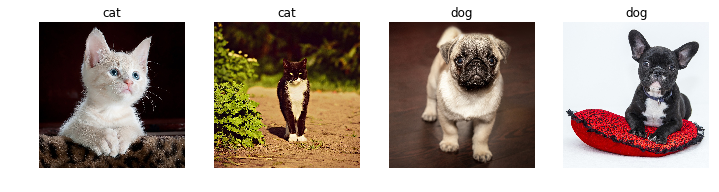

In [3]:
plt.figure(figsize=(12,8))

plt.subplot(141)
plt.title("cat")
plt.imshow(img1)
plt.axis('off')

plt.subplot(142)
plt.title("cat")
plt.imshow(img2)
plt.axis('off')

plt.subplot(143)
plt.title("dog")
plt.imshow(img3)
plt.axis('off')

plt.subplot(144)
plt.title("dog")
plt.imshow(img4)
plt.axis('off')
plt.show()

At test time we are asked to classify the following images:

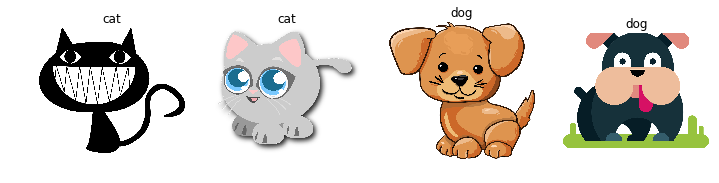

In [4]:
plt.figure(figsize=(12,8))

plt.subplot(141)
plt.title("cat")
plt.imshow(img5)
plt.axis('off')

plt.subplot(142)
plt.title("cat")
plt.imshow(img6)
plt.axis('off')

plt.subplot(143)
plt.title("dog")
plt.imshow(img7)
plt.axis('off')

plt.subplot(144)
plt.title("dog")
plt.imshow(img8)
plt.axis('off')
plt.show()

Obviously this is unlikely to work well.
The training set consists of photos,
while the test set contains only cartoons.
The colors aren't even realistic.
Training on a dataset that looks substantially different from the test set
without some plan for how to adapt to the new domain is a bad idea.
Unfortunately, this is a very common pitfall.
Statisticians call this *covariate shift*
because the root of the problem owed to
a shift in the distribution of features (i.e., of *covariates*).
Mathematically, we could say that $p(\mathbf{x})$ changes
but that $p(y|\mathbf{x})$ remains unchanged.
Although its usefulness is not restricted to this setting,
when we believe $\mathbf{x}$ causes $y$, covariate shift is usually
the right assumption to be working with.

### Label Shift

The converse problem emerges when we believe that what drives the shift
is a change in the marginal distribution over the labels $p(y)$
but that the class-conditional distributions are invariant $p(\mathbf{x}|y)$.
Label shift is a reasonable assumption to make
when we beleive that $y$ causes $\mathbf{x}$.
For example, commonly we want to predict a diagnosis given its manifestations.
In this case we beleive that the diagnosis causes the manifestations,
i.e., diseases cause symptoms.
Sometimes the label shift and covariate shift assumptions
can hold simultaneously.
For example, when the true labeling function is deterministic and unchanging,
then covariate shift will always hold,
including if label shift holds too.
Interestingly, when we expect both label shift and covariate shift hold,
it's often advantageous to work with the methods
that flow from the label shift assumption.
That's because these methods tend to involve manipulating objects
that look like the label,
which (in deep learning) tends to be comparatively easy
compared to working with the objects that look like the input,
which tends (in deep learning) to be a high-dimensional object.



### Concept Shift

One more related problem arises in *concept shift*,
the situation in which the very label definitions change.
This sounds weird—after all, a *cat* is a *cat*.
Indeed the definition of a cat might not change,
but can we say the same about soft drinks?
It turns out that if we navigate aroudn the United States,
shifting the source of our data by geography,
we'll find considerable concept shift regaring
the definition of even this simple term:

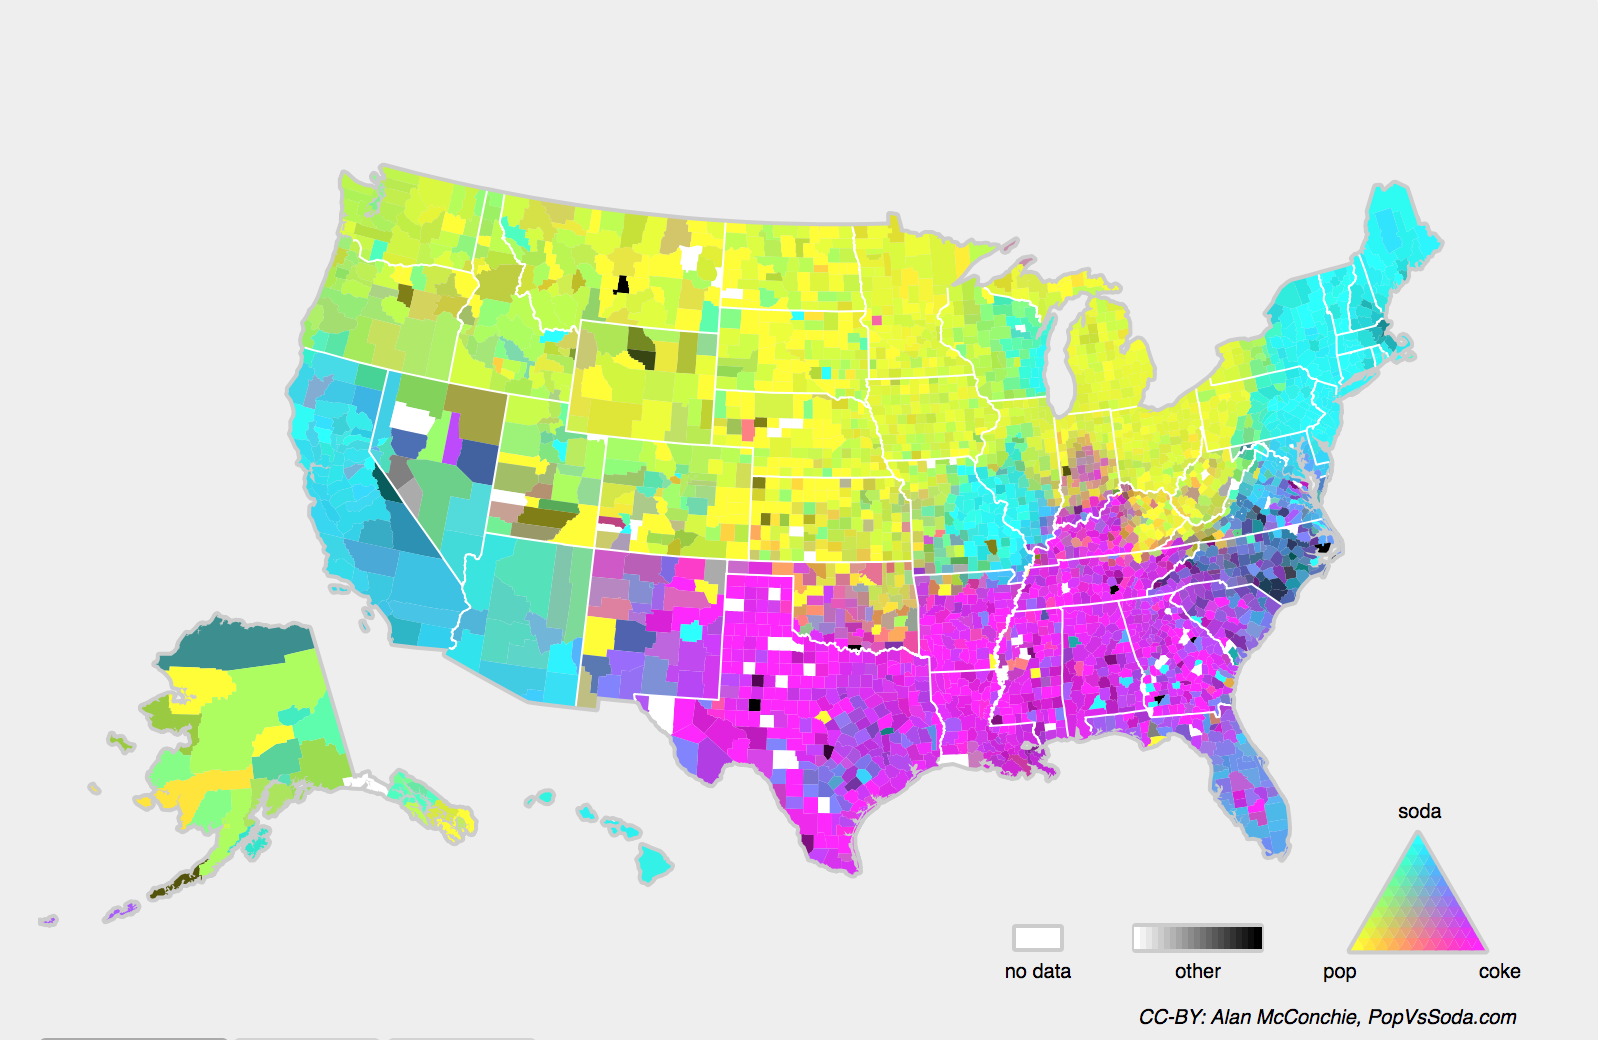

In [5]:
from IPython.display import display, Image
display(Image(filename='../img/popvssoda.png'))

If we were to build a machine translation system,
the distribution $p(y|x)$ might be different
depending on our location.
This problem can be tricky to spot.
A saving grace is that often the $p(y|x)$ only shifts gradually.
Before we go into further detail and discuss remedies,
we can discuss a number of situations where covariate and concept shift
may not be so obvious.



### Examples

#### Medical Diagnostics

Imagine that you want to design an algorithm to detect cancer.
You collect data from healthy and sick people and you train your algorithm.
It works fine, giving you high accuracy
and you conclude that you’re ready
for a successful career in medical diagnostics.
Not so fast...

Many things could go wrong.
In particular, the distributions that you work with
for training and those that you encounter in the wild
might differ considerably.
This happened to an unfortunate startup,
that Alex had the opportunity to consult for many years ago.
They were developing a blood test for a disease
that affects mainly older men and they’d managed to obtain
a fair amount of blood samples from patients.
It is considerably more difficult, though,
to obtain blood samples from healthy men (mainly for ethical reasons).
To compensate for that, they asked a large number of students on campus
to donate blood and they performed their test.
Then they asked me whether I could help them
build a classifier to detect the disease.
I told them that it would be very easy to distinguish
between both datasets with near-perfect accuracy.
After all, the test subjects differed in age, hormone levels,
physical activity, diet, alcohol consumption,
and many more factors unrelated to the disease.
This was unlikely to be the case with real patients:
Their sampling procedure made it likely that
an extreme case of covariate shift would arise
between the *source* and *target* distributions,
and at that, one that could not be corrected by conventional means.
In other words, training and test data were so different
that nothing useful could be done
and they had wasted significant amounts of money.

#### Self Driving Cars

Say a company wanted to build a machine learning system for self-driving cars.
One of the key components is a roadside detector.
Since real annotated data is expensive to get,
they had the (smart and questionable) idea
to use synthetic data from a game rendering engine
as additional training data.
This worked really well on 'test data' drawn from the rendering engine.
Alas, inside a real car it was a disaster.
As it turned out, the roadside had been rendered
with a very simplistic texture.
More importantly, *all* the roadside had been rendered
with the *same* texture and the roadside detector
learned about this 'feature' very quickly.

A similar thing happened to the US Army
when they first tried to detect tanks in the forest.
They took aerial photographs of the forest without tanks,
then drove the tanks into the forest and took another set of pictures.
The so-trained classifier worked 'perfectly'.
Unfortunately, all it had learned was to distinguish trees
with shadows from trees without shadows—the
first set of pictures was taken in the early morning, the second one at noon.

#### Nonstationary distributions

A much more subtle situation arises when the distribution changes slowly
and the model is not updated adequately.
Here are some typical cases:

* We train a computational advertising model and then fail to update it frequently (e.g. we forget to incorporate that an obscure new device called an iPad was just launched).
* We build a spam filter. It works well at detecting all spam that we've seen so far. But then the spammers wisen up and craft new messages that look unlike anything we've seen before.
* We build a product recommendation system. It works throughout the winter... but then it keeps on recommending Santa hats long after Christmas.

#### More Anecdotes

* We build a face detector. It works well on all benchmarks. Unfortunately it fails on test data - the offending examples are close-ups where the face fills the entire image (no such data was in the training set).
* We build a web search engine for the USA market and want to deploy it in the UK.
* We train an image classifier by compiling a large dataset where each among a large set of classes is equally represented in the dataset, say 1000 categories, represented by 1000 images each. Then we deploy the system in the real world, where the actual label distirbution of photographs is decidedly non-uniform.

In short, there are many cases where training and test distributions
$p(\mathbf{x}, y)$ are different.
In some cases, we get lucky and the models work
despite covariate, label, or concept shift.
In other cases, we can do better by employing
principled strategies to cope with the shift.
The remainder of this section grows considerably more technical.
The impatient reader could continue on to the next section
as this material is not prerequisite to subsequent concepts.

### Covariate Shift Correction

Assume that we want to estimate some dependency $p(y|\mathbf{x})$
for which we have labeled data $(\mathbf{x}_i,y_i)$.
Unfortunately, the observations $x_i$ are drawn
from some *target* distribution $q(\mathbf{x})$
rather than the *source* distribution $p(\mathbf{x})$.
To make progress, we need to reflect about what exactly
is happening during training:
we iterate over training data and associated labels
$\{(\mathbf{x}_1, y_1), \ldots (\mathbf{x}_n, y_n)\}$
and update the weight vectors of the model after every minibatch.
We sometimes additionally apply some penalty to the parameters,
using weight decay, dropout, or some other related technique.
This means that we largely minimize the loss on the training.

$$
\mathrm{minimize}_w \frac{1}{n} \sum_{i=1}^n l(x_i, y_i, f(x_i)) + \mathrm{some~penalty}(w)
$$


Statisticians call the first term an *empirical average*,
i.e., an average computed over the data drawn from $p(x) p(y|x)$.
If the data is drawn from the 'wrong' distribution $q$,
we can correct for that by using the following simple identity:

$$
\begin{aligned}
\int p(\mathbf{x}) f(\mathbf{x}) dx & = \int p(\mathbf{x}) f(\mathbf{x}) \frac{q(\mathbf{x})}{q(\mathbf{x})} dx \\
& = \int q(\mathbf{x}) f(\mathbf{x}) \frac{p(\mathbf{x})}{q(\mathbf{x})} dx
\end{aligned}
$$

In other words, we need to re-weight each instance
by the ratio of probabilities
that it would have been drawn from the correct distribution
$\beta(\mathbf{x}) := p(\mathbf{x})/q(\mathbf{x})$.
Alas, we do not know that ratio,
so before we can do anything useful we need to estimate it.
Many methods are available,
including some fancy operator-theoretic approaches
that attempt to recalibrate the expectation operator directly
using a minimum-norm or a maximum entropy principle.
Note that for any such approach, we need samples
drawn from both distributions—the 'true' $p$, e.g.,
by access to training data, and the one used
for generating the training set $q$ (the latter is trivially available).
Note however, that we only need samples $\mathbf{x} \sim q(\mathbf{x})$;
we do not to access labels labels $y \sim q(y)$.

In this case, there exists a very effective approach
that will give almost as good results: logistic regression.
This is all that is needed to compute estimate probability ratios.
We learn a classifier to distinguish between data drawn from $p(\mathbf{x})$
and data drawn from $q(x)$.
If it is impossible to distinguish between the two distributions
then it means that the associated instances are equally likely
to come from either one of the two distributions.
On the other hand, any instances that can be well discriminated
should be significantly over/underweighted accordingly.
For simplicity’s sake assume that we have an equal number of instances
from both distributions, denoted by $\mathbf{x}_i \sim p(\mathbf{x})$ and $\mathbf{x}_i' \sim q(\mathbf{x})$ respectively.
Now denote by $z_i$ labels which are 1
for data drawn from $p$ and -1 for data drawn from $q$.
Then the probability in a mixed dataset is given by

$$p(z=1|\mathbf{x}) = \frac{p(\mathbf{x})}{p(\mathbf{x})+q(\mathbf{x})} \text{ and hence } \frac{p(z=1|\mathbf{x})}{p(z=-1|\mathbf{x})} = \frac{p(\mathbf{x})}{q(\mathbf{x})}$$

Hence, if we use a logistic regression approach where $p(z=1|\mathbf{x})=\frac{1}{1+\exp(-f(\mathbf{x}))}$ it follows that

$$
\beta(\mathbf{x}) = \frac{1/(1 + \exp(-f(\mathbf{x})))}{\exp(-f(\mathbf{x})/(1 + \exp(-f(\mathbf{x})))} = \exp(f(\mathbf{x}))
$$

As a result, we need to solve two problems:
first one to distinguish between data drawn from both distributions,
and then a reweighted minimization problem
where we weigh terms by $\beta$, e.g. via the head gradients.
Here's a prototypical algorithm for that purpose
which uses an unlabeled training set $X$ and test set $Z$:

1. Generate training set with $\{(\mathbf{x}_i, -1) ... (\mathbf{z}_j, 1)\}$
1. Train binary classifier using logistic regression to get function $f$
1. Weigh training data using $\beta_i = \exp(f(\mathbf{x}_i))$ or better $\beta_i = \min(\exp(f(\mathbf{x}_i)), c)$
1. Use weights $\beta_i$ for training on $X$ with labels $Y$

Note that this method relies on a crucial assumption.
For this scheme to work, we need that each data point
in the tartget (test time)distribution
had nonzero probability of occuring at training time.
If we find a point where $q(\mathbf{x}) > 0$ but $p(\mathbf{x}) = 0$,
then the corresponding importance weight should be infinity.

**Generative Adversarial Networks**
use a very similar idea to that described above
to engineer a *data generator* that outputs data
that cannot be distinguished
from examples sampled from a reference dataset.
In these approaches, we use one network, $f$
to distinguish real versus fake data
and a second network $g$ that tries to fool the discriminator $f$
into accepting fake data as real.
We will discuss this in much more detail later.


### Label Shift Correction

For the discussion of label shift,
we'll assume for now that we are dealing
with a $k$-way multiclass classification task.
When the distribution of labels shifts over time $p(y) \neq q(y)$
but the class-conditional distributions stay the same
$p(\mathbf{x})=q(\mathbf{x})$,
our importance weights will correspond to the
label likelihood ratios $q(y)/p(y)$.
One nice thing about label shift is that
if we have a reasonably good model (on the source distribution)
then we can get consistent estimates of these weights
without ever having to deal with the ambient dimension
(in deep learning, the inputs are often high-dimensional perceptual objects like images, while the labels are often easier to work,
say vectors whose length corresponds to the number of classes).

To estimate calculate the target label distribution,
we first take our reasonably good off the shelf classifier
(typically trained on the training data)
and compute its confusion matrix using the validation set
(also from the training distribution).
The confusion matrix C, is simply a $k \times k$ matrix
where each column corresponsd to the *actual* label
and each row corresponds to our model's predicted label.
Each cell's value $c_{ij}$ is the fraction of predictions
where the true label was $j$ *and* our model predicted $y$.

Now we can't calculate the confusion matrix
on the target data directly,
because we don't get to see the labels for the examples
that we see in the wild,
unless we invest in a complex real-time annotation pipeline.
What we can do, however, is average all of our models predictions
at test time together, yielding the mean model output $\mu_y$.

It turns out that under some mild conditions—
if our classifier was reasonably accurate in the first place,
if the target data contains only classes of images that we've seen before,
and if the label shift assumption holds in the first place
(far the strongest assumption here),
then we can recover the test set label distribution by solving
a simple linear system $C \cdot q(y) = \mu_y$.
If our classifier is sufficiently accurate to begin with,
then the confusion C will be invertible,
and we get a solution $q(y) = C^{-1} \mu_y$.
Here we abuse notation a bit, using $q(y)$
to denote the vector of label frequencies.
Because we observe the labels on the source data,
it's easy to estimate the distribution $p(y)$.
Then for any training example $i$ with label $y$,
we can take the ratio of our estimates $\hat{q}(y)/\hat{p}(y)$
to calculate the weight $w_i$,
and plug this into the weighted risk minimization algorithm above.


### Concept Shift Correction

Concept shift is much harder to fix in a principled manner.
For instance, in a situation where suddenly the problem changes
from distinguishing cats from dogs to one of
distinguishing white from black animals,
it will be unreasonable to assume
that we can do much better than just collecting new labels
and training from scratch.
Fortunately, in practice, such extreme shifts are rare.
Instead, what usually happens is that the task keeps on changing slowly.
To make things more concrete, here are some examples:

* In computational advertising, new products are launched, old products become less popular. This means that the distribution over ads and their popularity changes gradually and any click-through rate predictor needs to change gradually with it.
* Traffic cameras lenses degrade gradually due to environmental wear, affecting image quality progressively.
* News content changes gradually (i.e. most of the news remains unchanged but new stories appear).

In such cases, we can use the same approach that we used for training networks to make them adapt to the change in the data. In other words, we use the existing network weights and simply perform a few update steps with the new data rather than training from scratch.

## A Taxonomy of Learning Problems

Armed with knowledge about how to deal with changes in $p(x)$ and in $p(y|x)$, we can now consider some other aspects of machine learning problems formulation.


* **Batch Learning.** Here we have access to training data and labels $\{(x_1, y_1), \ldots (x_n, y_n)\}$, which we use to train a network $f(x,w)$. Later on, we deploy this network to score new data $(x,y)$ drawn from the same distribution. This is the default assumption for any of the problems that we discuss here. For instance, we might train a cat detector based on lots of pictures of cats and dogs. Once we trained it, we ship it as part of a smart catdoor computer vision system that lets only cats in. This is then installed in a customer's home and is never updated again (barring extreme circumstances).
* **Online Learning.** Now imagine that the data $(x_i, y_i)$ arrives one sample at a time. More specifically, assume that we first observe $x_i$, then we need to come up with an estimate $f(x_i,w)$ and only once we've done this, we observe $y_i$ and with it, we receive a reward (or incur a loss), given our decision. Many real problems fall into this category. E.g. we need to predict tomorrow's stock price, this allows us to trade based on that estimate and at the end of the day we find out whether our estimate allowed us to make a profit. In other words, we have the following cycle where we are continuously improving our model given new observations.

$$
\mathrm{model} ~ f_t \longrightarrow
\mathrm{data} ~ x_t \longrightarrow
\mathrm{estimate} ~ f_t(x_t) \longrightarrow
\mathrm{observation} ~ y_t \longrightarrow
\mathrm{loss} ~ l(y_t, f_t(x_t)) \longrightarrow
\mathrm{model} ~ f_{t+1}
$$

* **Bandits.** They are a *special case* of the problem above. While in most learning problems we have a continuously parametrized function $f$ where we want to learn its parameters (e.g. a deep network), in a bandit problem we only have a finite number of arms that we can pull (i.e. a finite number of actions that we can take). It is not very surprising that for this simpler problem stronger theoretical guarantees in terms of optimality can be obtained. We list it mainly since this problem is often (confusingly) treated as if it were a distinct learning setting.
* **Control (and nonadversarial Reinforcement Learning).** In many cases the environment remembers what we did. Not necessarily in an adversarial manner but it'll just remember and the response will depend on what happened before. E.g. a coffee boiler controller will observe different temperatures depending on whether it was heating the boiler previously. PID (proportional integral derivative) controller algorithms are a popular choice there. Likewise, a user's behavior on a news site will depend on what we showed him previously (e.g. he will read most news only once). Many such algorithms form a model of the environment in which they act such as to make their decisions appear less random (i.e. to reduce variance).
* **Reinforcement Learning.** In the more general case of an environment with memory, we may encounter situations where the environment is trying to *cooperate* with us (cooperative games, in particular for non-zero-sum games), or others where the environment will try to *win*. Chess, Go, Backgammon or StarCraft are some of the cases. Likewise, we might want to build a good controller for autonomous cars. The other cars are likely to respond to the autonomous car's driving style in nontrivial ways, e.g. trying to avoid it, trying to cause an accident, trying to cooperate with it, etc.

One key distinction between the different situations above is that the same strategy that might have worked throughout in the case of a stationary environment, might not work throughout when the environment can adapt. For instance, an arbitrage opportunity discovered by a trader is likely to disappear once he starts exploiting it. The speed and manner at which the environment changes determines to a large extent the type of algorithms that we can bring to bear. For instance, if we *know* that things may only change slowly, we can force any estimate to change only slowly, too. If we know that the environment might change instantaneously, but only very infrequently, we can make allowances for that. These types of knowledge are crucial for the aspiring data scientist to deal with concept shift, i.e. when the problem that he is trying to solve changes over time.


## Fairness, Accountability, and Transparency in machine Learning

Finally, it's important to remember
that when you deploy machine learning systems
you aren't simply minimizing negative log likelihood
or maximizing accuracy—you are automating some kind of decision process.
Often the automated decision-making systems that we deploy
can have consequences for those subject to its decisions.
If we are deploying a medical diagnostic system,
we need to know for which populations it may work and which it may not.
Overlooking forseeable risks to the welfare of a subpopulation
would run afoul of basic ethical principles.
Moreover, "accuracy" is seldom the right metric.
When translating predictions in to actions
we'll often want to take into account the potential cost sensitivity
of erring in various ways.
If one way that you might classify an image could be perceived as a racial sleight, while misclassification to a different category
would be harmless, then you might want to adjust your thresholds
accordingly, accounting for societal values
in designing the decision-making protocol.
We also want to be careful about how prediction systems
can lead to feedback loops.
For example, if prediction systems are applied naively to predictive policing,
allocating patrol officers accordingly, a vicious cycle might emerge.
Neighborhoods that have more crimes, get more patrols, get more crimes discovered, get more training data, get yet more confident predictions, leading to even more patrols, even more crimes discovered, etc.
Additionally, we want to be careful about whether we are addressing the right problem in the first place. Predictive algorithms now play an outsize role in mediating the dissemination of information.
Should what news someone is exposed to be determined by which Facebook pages they have *Liked*? These are just a few among the many profound ethical dilemmas that you might encounter in a career in machine learning.



## Summary

* In many cases training and test set do not come from the same distribution. This is called covariate shift.
* Covariate shift can be detected and corrected if the shift isn't too severe. Failure to do so leads to nasty surprises at test time.
* In some cases the environment *remembers* what we did and will respond in unexpected ways. We need to account for that when building models.

## Exercises

1. What could happen when we change the behavior of a search engine? What might the users do? What about the advertisers?
1. Implement a covariate shift detector. Hint - build a classifier.
1. Implement a covariate shift corrector.
1. What could go wrong if training and test set are very different? What would happen to the sample weights?




